<a href="https://colab.research.google.com/github/yohan2001colombo/pyTorch/blob/main/CNN_trained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image



In [2]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [3]:
train_data = torchvision.datasets.CIFAR10(root="/image",train=True, download=True, transform=transforms)
test_data = torchvision.datasets.CIFAR10(root="/image",train=False, download=True, transform=transforms)

100%|██████████| 170M/170M [00:10<00:00, 15.9MB/s]


In [4]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /image
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [26]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=10,shuffle=True)


In [27]:
image,label = train_data[100]
image.size()

torch.Size([3, 32, 32])

In [28]:
label

8

In [81]:
labels = ["plane","car","bird","cat","deer","dog","frog","horse","ship","truck"]

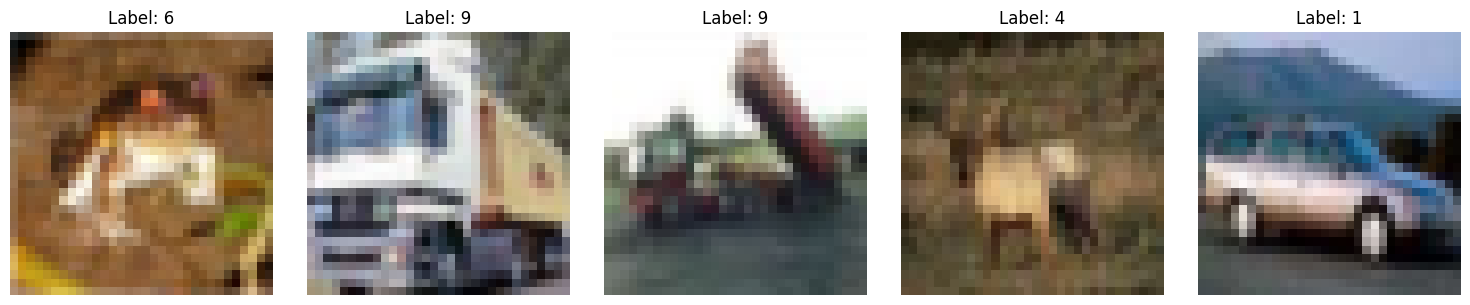

In [32]:
plt.figure(figsize=(15, 3))

for i, (image, label) in enumerate(train_data):
    if i < 5:  # Print the first 5 samples
        plt.subplot(1, 5, i + 1)

        # If image is a PyTorch tensor, convert to numpy and adjust dimensions
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).cpu().numpy()  # CxHxW → HxWxC

        # **Renormalize from [-1, 1] to [0, 1]**
        # image = (image - image.min()) / (image.max() - image.min())  # Rescale to [0, 1]
        # OR (if you know normalization was mean=0.5, std=0.5)
        image = (image * 0.5) + 0.5  # Rescale back to [0, 1]

        plt.imshow(image)
        plt.title(f"Label: {label}")
        plt.axis('off')
    else:
        break

plt.tight_layout()
plt.show()

In [33]:
conv1 = nn.Conv2d(3,12,5)
conv2 = nn.Conv2d(12,24,5)
res = conv1(image)
res.shape
res = F.max_pool2d(res,2,2)
res.shape
res = conv2(res)
res.shape
res = F.max_pool2d(res,2,2)
res.shape

torch.Size([24, 5, 5])

In [34]:
class Nueral(nn.Module):
  def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3,12,5) # kernel 5x5
      self.conv2 = nn.Conv2d(12,24,5)
      # full connected layer
      self.fc1 = nn.Linear(24*5*5,120)
      self.fc2 = nn.Linear(120,84)
      self.fc3 = nn.Linear(84,10)

  def forward(self,x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x,2,2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x,2,2)

      x = x.view(-1,24*5*5)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)

      return x

In [39]:
net = Nueral()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(),lr=0.005)

In [36]:
net

Nueral(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [40]:
for epoch in range(10):
  print(f'Training epoch {epoch}')

  running_loss = 0

  for i,data in enumerate(train_loader):
    inputs,labels = data
    optimizer.zero_grad()
    outputs = net(inputs)
    loss_value = loss(outputs,labels)
    loss_value.backward()
    optimizer.step()

    running_loss += loss_value.item()
  print(f'Loss: {running_loss/len(train_loader)}')

Training epoch 0
Loss: 2.0583679805278776
Training epoch 1
Loss: 1.5470157893896104
Training epoch 2
Loss: 1.3601741825282574
Training epoch 3
Loss: 1.2376887858748435
Training epoch 4
Loss: 1.138902955967188
Training epoch 5
Loss: 1.0602147484093905
Training epoch 6
Loss: 0.9977213952809573
Training epoch 7
Loss: 0.943354160836339
Training epoch 8
Loss: 0.8974924363821745
Training epoch 9
Loss: 0.8542320792809128


In [41]:
torch.save(net.state_dict(),'trained_net_pth')


In [42]:
net = Nueral()
net.load_state_dict(torch.load('trained_net_pth'))

<All keys matched successfully>

In [43]:
corrrect = 0
total = 0

net.eval()

with torch.no_grad():
  for data in test_loader:
    images,labels = data
    outputs = net(images)
    _,predicted = torch.max(outputs.data,1)
    total += labels.size(0)
    corrrect += (predicted == labels).sum().item()

accuracy = corrrect/total
print(f'Accuracy: {accuracy}')

Accuracy: 0.6547


In [76]:
from google.colab import files

# This will open a file dialog to select images from your computer
uploaded = files.upload()

# The images are now in your Colab environment
for filename in uploaded.keys():
    print(f'Uploaded {filename} ({len(uploaded[filename])} bytes)')

Saving labrador-retriever-1210559_1280.jpg to labrador-retriever-1210559_1280.jpg
Uploaded labrador-retriever-1210559_1280.jpg (236483 bytes)


In [84]:
new_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

def load_image(image_path):
  image = Image.open(image_path)
  image = new_transform(image)
  image = image.unsqueeze(0)
  return image

image_paths = ['labrador-retriever-1210559_1280.jpg']
images = [load_image(img) for img in image_paths]

net.eval()
with torch.no_grad():
  for image in images:
    output = net(image)
    _,predicted = torch.max(output.data,1)
    print(f'Predicted: {labels[predicted.item()]}')

Predicted: dog


In [80]:
label

1